# Visulise the benthic type spectral library

The spectra (reflectance as function of wavelength) of a variety of bottom types (Table 1) gathered through in-situ hyperspectral measruements by Dr Eric Hochberg ([*Spectral reflectance of coral reef bottom-types worldwide and implications for coral reef remote sensing*](https://doi.org/10.1016/S0034-4257(02)00201-8)) comprise the endmember library of bottom types.

This notebook explores the distribution of endmember spectra.

| Endmember category        | Number of samples | Mean reflectance |
|---------------------------|-------------------|------------------|
| algae_crustose_coralline  |       450         | 0.076286         |
| algae_fleshy_brown        |       252         | 0.051969         |
| algae_fleshy_green        |       865         | 0.030309         |
| algae_fleshy_red          |       764         | 0.018441         |
| algae_turf                |       817         | 0.101880         |
| coral_blue                |       395         | 0.073091         |
| coral_brown               |       1466        | 0.056770         |
| mud                       |       498         | 0.034284         |
| octocoral                 |       163         | 0.082487         |
| sand                      |       40          | 0.545028         |
| seagrass                  |       221         | 0.040415         |
**Table 1** Summary statistics of endmember categories


In [26]:
%load_ext autoreload
%autoreload 2

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, TruncatedSVD

# custom
from reflectance import file_ops, optimisation_pipeline, plotting, spectrum_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualise library

In [27]:
# read in spectral library
spectral_library_df = spectrum_utils.load_spectral_library()

In [49]:
int(np.ceil(len(cats)/2))

5

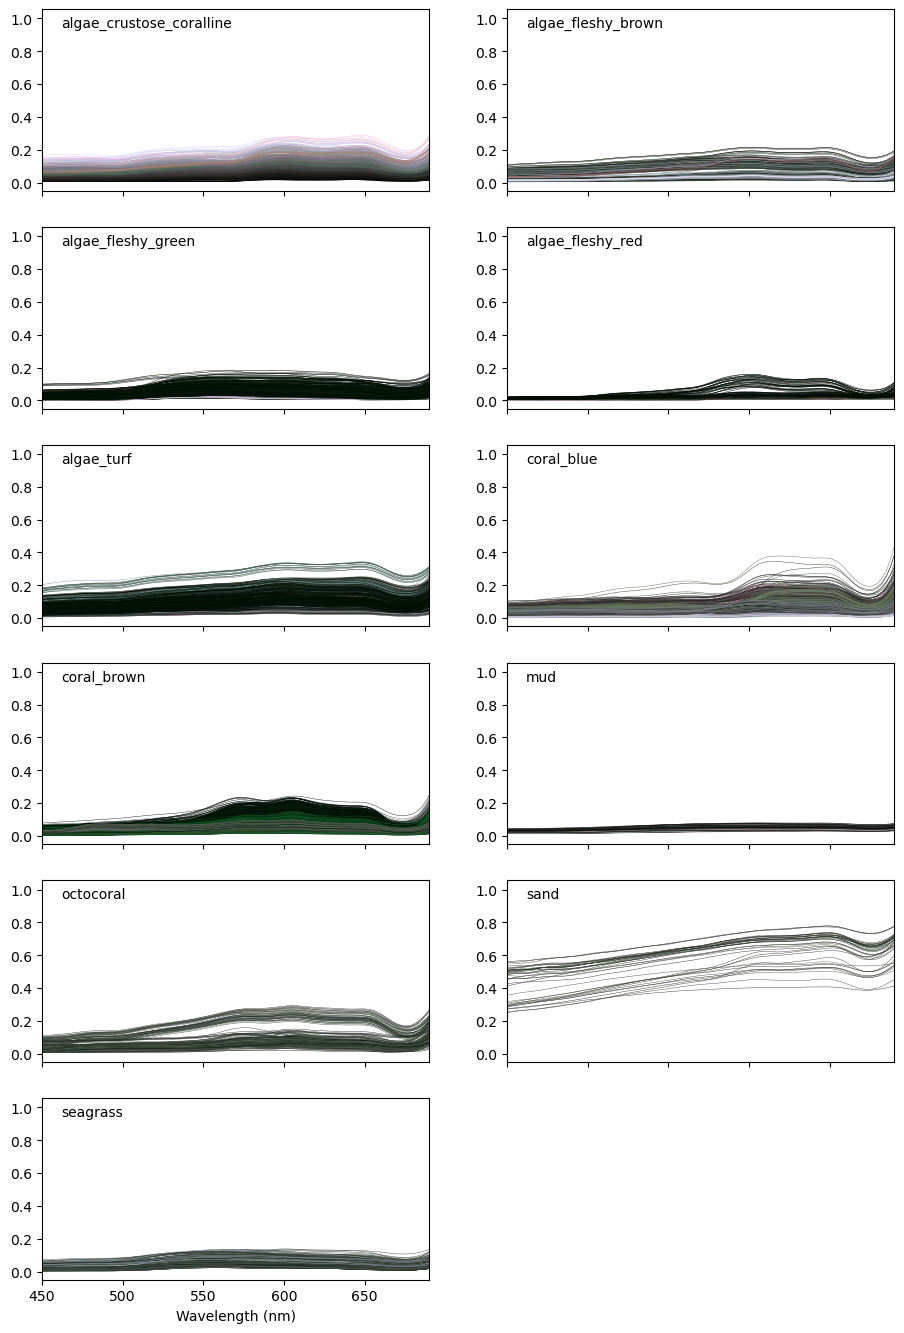

In [55]:
# plot spectra with colours normalised internal to each category
cats = spectral_library_df.index.unique()

fig, axs = plt.subplots(int(np.ceil(len(cats)/2)), 2, figsize=[len(cats)/2 * 2, len(cats)/2 * 3], sharex=True, constrained_layout=False)

snum = 0
axs = axs.ravel()
for cat, ax in zip(cats, axs):
    ind = spectral_library_df.index == cat
    spectra = spectral_library_df.loc[ind].values
    # calculate rgb values  # TODO: these don't look physical
    rgb_normed = plotting.generate_and_visualise_spectral_colours(spectral_library_df)
    
    for s, spectrum in enumerate(spectra):
        ax.plot(spectral_library_df.columns, spectrum, color=rgb_normed[s], alpha=1, lw=0.3)
        snum += 1
            
    ax.text(0.05, 0.9, cat, fontsize=10, transform=ax.transAxes, ha='left')
    ax.set_xlim(spectrum_utils.SENSOR_RANGE)
    
[fig.delaxes(ax) for ax in axs if not ax.has_data()]

# set the y lims of the axes to be the same
ymin = min([ax.get_ylim()[0] for ax in axs])
ymax = max([ax.get_ylim()[1] for ax in axs])
[ax.set_ylim(ymin, ymax) for ax in axs]
ax.set_xlabel('Wavelength (nm)');

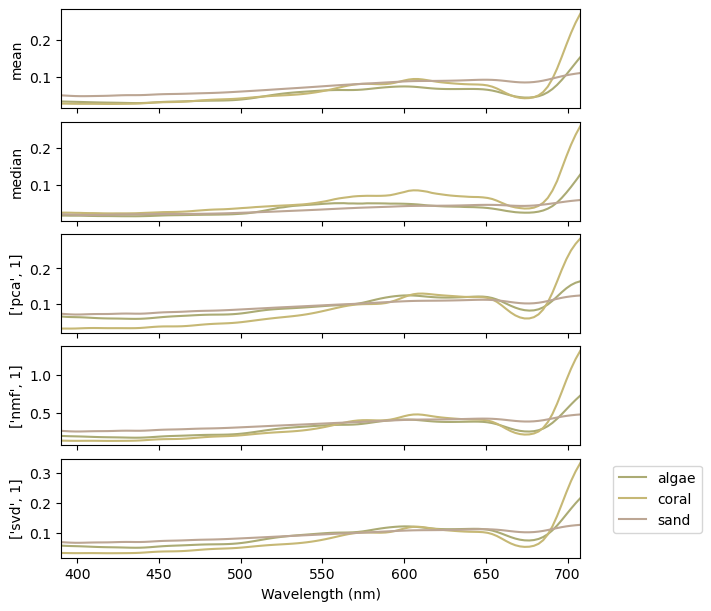

In [63]:
# plot subcategorisation of spectra coloured by a predetermined colour scheme

# create dictionary of colours for each endmember
color_dict = {
    "algae_crustose_coralline": (255,205,210),
    "algae_fleshy_brown": (130, 119, 23),
    "algae_fleshy_green": (129, 199, 132),
    "algae_fleshy_red": (255, 171, 145),
    "algae_turf": (230, 238, 156),
    "coral_blue": (178, 223, 219),
    "coral_brown": (161, 136, 127),
    "octocoral": (255, 193, 7),
    "mud": (121, 85, 72),
    "sand": (255, 248, 225),
    "seagrass": (27, 94, 32)
}

class_color_dict = {}

endmember_class_schema = "three_endmember"
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
endmember_classes = glob_cfg.endmember_schema[endmember_class_schema]

class_subclass_dict = endmember_classes
subclass_color_dict = color_dict
for class_name, subclasses in class_subclass_dict.items():
    # Fetch the colors of the subclasses
    subclass_colors = np.array([subclass_color_dict[subclass] for subclass in subclasses])
    
    combined_color = tuple(subclass_colors.mean(axis=0).astype(int))
    # normalise
    combined_color = tuple([c/255 for c in combined_color])
    # Store the combined color in the new dictionary
    class_color_dict[class_name] = combined_color
    
# visualise components of endmembers
dimensionality_reduction_types = ["mean", "median", ["pca", 1], ["nmf", 1], ["svd",1]]

fig, ax = plt.subplots(nrows=len(dimensionality_reduction_types), figsize=[7, len(dimensionality_reduction_types) * 1.2], sharex=True, constrained_layout=True)

endmember_class_schema = "three_endmember"
for i, dr in enumerate(dimensionality_reduction_types):
    endmembers = optimisation_pipeline.GenerateEndmembers(
        endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
        endmember_dimensionality_reduction = dr
        ).generate_endmembers()
    for endmember in endmembers.index:
        if isinstance(endmember, tuple):
            endmember = endmember[0]
        ax[i].plot(df.columns, endmembers.loc[endmember].T, alpha=1, lw=1.5, color=class_color_dict[endmember])
    ax[i].set_ylabel(dimensionality_reduction_types[i])
    ax[i].set_xlim(min(df.columns), max(df.columns))

ax[-1].legend([em[0] for em in endmembers.index], bbox_to_anchor=(1.05,1), loc='upper left')
ax[-1].set_xlabel('Wavelength (nm)');

In [64]:
mean_spectra = df.groupby(df.index).mean()

# order mean_spectra by index containing 'algae' first, then 'coral', then 'seagrass', then 'sand', then 'mud'
mean_spectra = mean_spectra.reindex(mean_spectra.index[mean_spectra.index.str.contains('algae')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('coral')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('seagrass')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('sand')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('mud')].tolist())
mean_spectra

,390.346814,393.177859,396.008959,398.840115,401.671328,404.502597,407.333922,410.165304,412.996742,415.828236,...,682.239779,685.076616,687.913509,690.750458,693.587464,696.424526,699.261643,702.098818,704.936048,707.773335
wavelength,,,,,,,,,,,,,,,,,,,,,
algae_crustose_coralline,0.054358,0.053066,0.052221,0.051684,0.051110,0.050343,0.049509,0.048654,0.047874,0.047253,...,0.063754,0.068874,0.076957,0.088201,0.102432,0.118989,0.136883,0.154938,0.172149,0.187811
algae_fleshy_brown,0.031926,0.031671,0.031309,0.030959,0.030691,0.030505,0.030368,0.030230,0.030074,0.029920,...,0.044501,0.049467,0.056801,0.066644,0.078730,0.092362,0.106625,0.120562,0.133422,0.144806
algae_fleshy_green,0.014024,0.013959,0.013797,0.013604,0.013419,0.013249,0.013112,0.012989,0.012865,0.012720,...,0.024035,0.027507,0.032404,0.039075,0.047794,0.058637,0.071483,0.086025,0.101895,0.118748
algae_fleshy_red,0.009379,0.009427,0.009392,0.009281,0.009114,0.008951,0.008866,0.008854,0.008878,0.008888,...,0.017896,0.019350,0.021705,0.025442,0.031082,0.038986,0.049270,0.061751,0.075985,0.091402
algae_turf,0.065372,0.064816,0.064287,0.063847,0.063387,0.062791,0.062087,0.061372,0.060732,0.060237,...,0.094669,0.102151,0.113253,0.127994,0.145880,0.165866,0.186615,0.206804,0.225535,0.242391
algae_crustose_coralline,0.054358,0.053066,0.052221,0.051684,0.051110,0.050343,0.049509,0.048654,0.047874,0.047253,...,0.063754,0.068874,0.076957,0.088201,0.102432,0.118989,0.136883,0.154938,0.172149,0.187811
coral_blue,0.031437,0.031932,0.032391,0.032715,0.032833,0.032776,0.032649,0.032521,0.032438,0.032415,...,0.070383,0.083279,0.102807,0.129211,0.161253,0.196151,0.230557,0.261757,0.288571,0.311744
coral_brown,0.024920,0.024433,0.023914,0.023530,0.023354,0.023317,0.023335,0.023323,0.023235,0.023082,...,0.040652,0.048376,0.061449,0.081006,0.107036,0.138036,0.171328,0.203830,0.233238,0.258011
octocoral,0.034357,0.035312,0.035834,0.036481,0.037124,0.037494,0.037686,0.037681,0.037513,0.037248,...,0.076221,0.089434,0.109071,0.134892,0.165335,0.197756,0.229188,0.257137,0.280307,0.298481


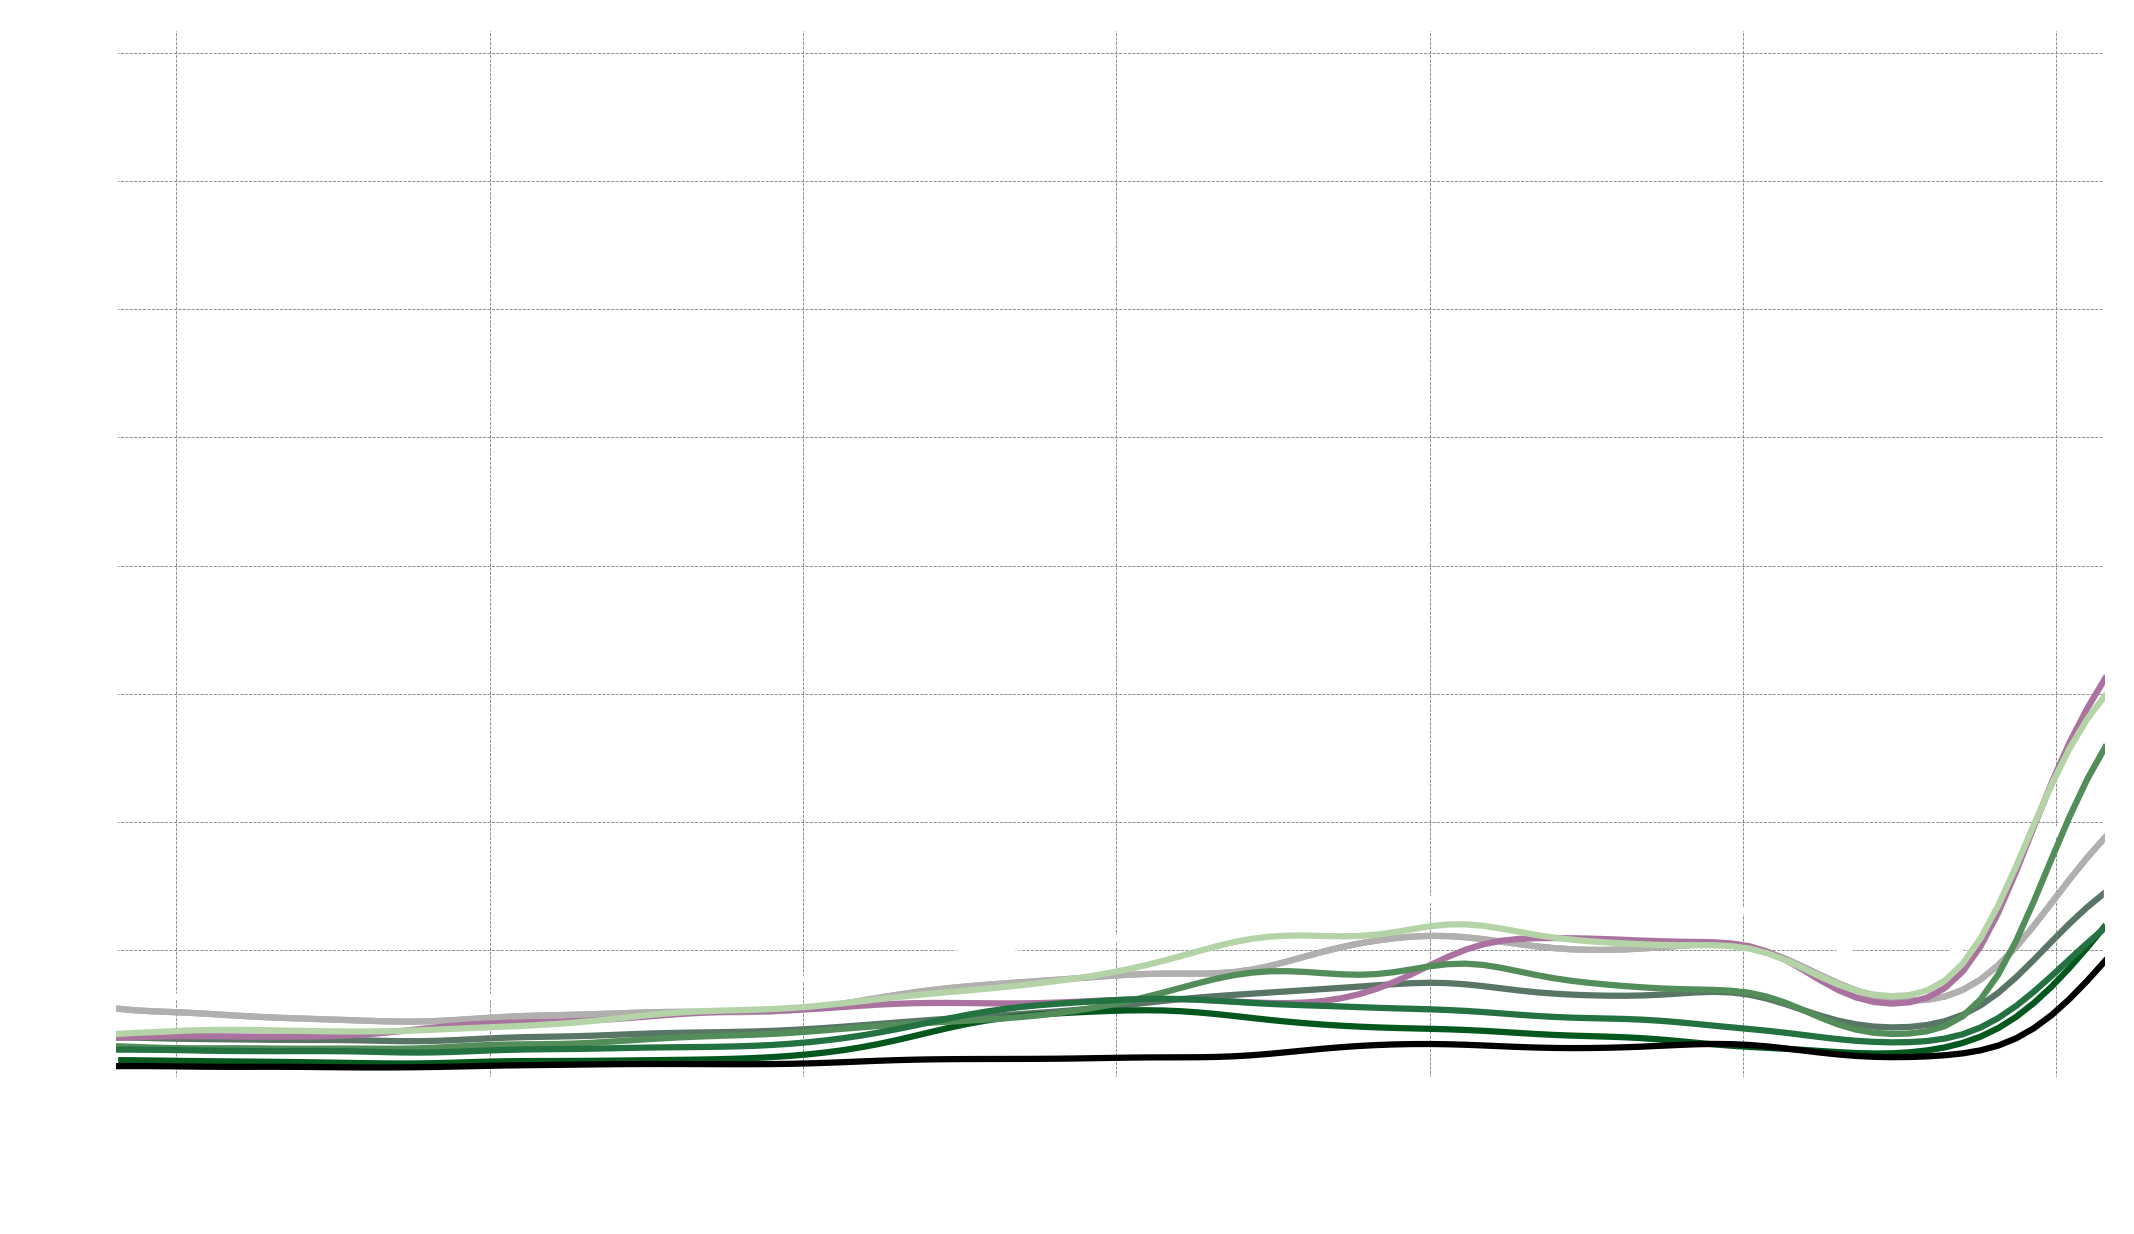

In [68]:
# plot desired means of classes

# exclude sand row (since biases colour hugely)
no_sand_mean_spectra = mean_spectra.drop('sand')
rgb_colours = plotting.generate_and_visualise_spectral_colours(no_sand_mean_spectra)
rgb_colours = np.concatenate((rgb_colours, [[0, 1, 1]]))

# create dictionary of names and colours
color_dict = dict(zip(mean_spectra.index, rgb_colours))
# plot all containing algae
fig, ax = plt.subplots(figsize=[7, 4], constrained_layout=True, dpi=300)


classes_to_plot = [
    'algae',
    'crustose',
    'coral',
    'seagrass',
    'sand`'
    ]
order = 0
for i, (index, spectra) in enumerate(mean_spectra.iterrows()):
    if any([c in index for c in classes_to_plot]):
        # only plot crustose if 'crustose' is in classes to plot
        if 'crustose' in index and 'crustose' not in classes_to_plot:
            continue
        else:
            ax.plot(df.columns, spectra, color=rgb_colours[i], alpha=1, lw=1.5, zorder=order)
            order += 1
        
# format
ax.set_xlabel('Wavelength (nm)', color="white")
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
ax.set_xlim(min(df.columns), max(df.columns))
plotting.format_axis_for_ppt(ax)
ax.set_yticklabels([])
ax.set_ylabel('Reflectance', color="white")
ax.grid(True, color="#7D7D7D", ls='--', linewidth=0.2, alpha=1, which='both')
# save result
fn = "mean_" + "_".join(classes_to_plot) + "_spectra"
fig.savefig(file_ops.RESULTS_DIR_FP / f"figures/{fn}.png", dpi=300, transparent=True)

In [73]:
# remap classes with nicer names for display
map_dict = {
    'algae_crustose_coralline': "CCA", 
    'algae_fleshy_brown': "brown algae",
    'algae_fleshy_green': "green algae",
    'algae_fleshy_red': "red algae",
    'algae_turf': "turf algae",
    'coral_blue': "blue coral",
    'coral_brown': "brown coral",
    'octocoral': "octocoral",
    'seagrass': 'seagrass',
    'mud': "mud",
    'sand': 'sand',
}
# rename df indices
remapped_df = df.copy()
remapped_df.index = [map_dict[c] for c in remapped_df.index]

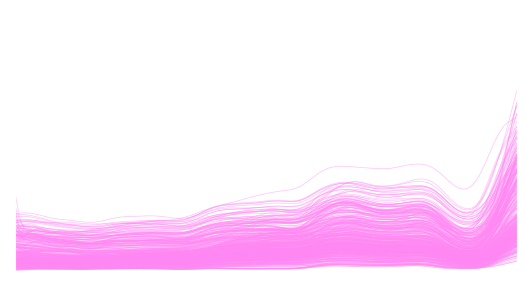

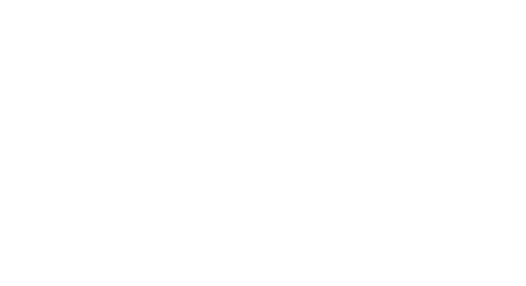

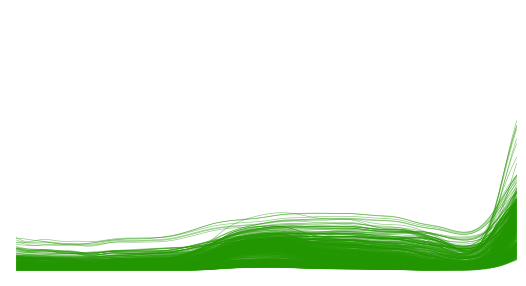

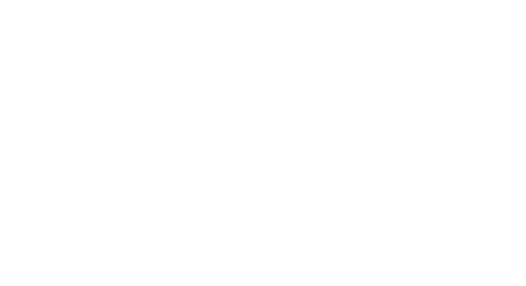

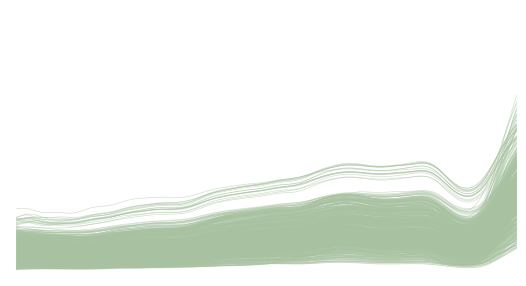

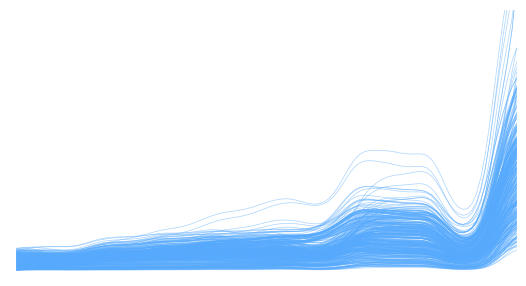

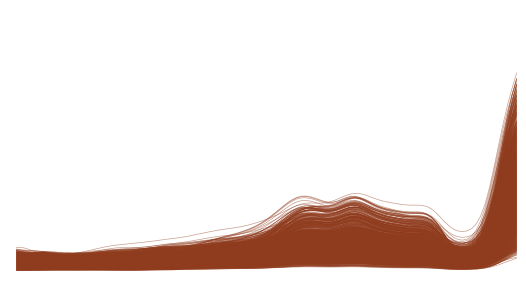

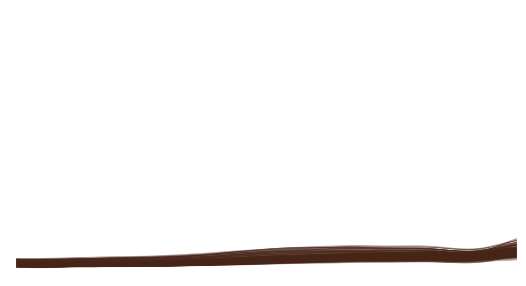

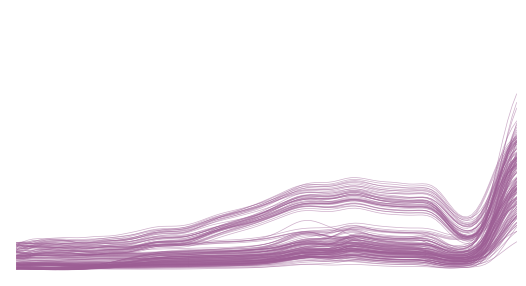

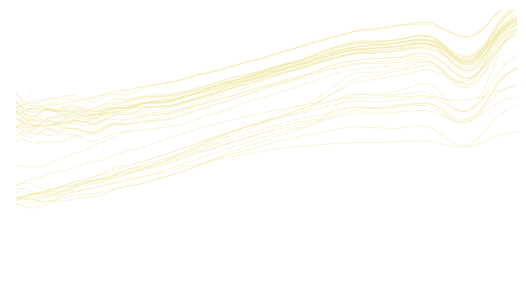

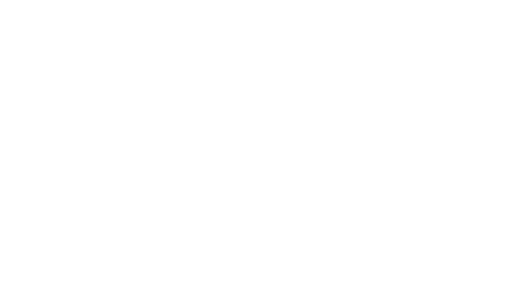

In [72]:
# plot each class with an illustrative colour

color_dict = {
    'CCA': "#ff87f3",
    'brown algae': "#FFFFFF",
    'green algae': "#219600",
    'red algae': "#FFFFFF",
    'turf algae': "#a8c2a1",
    'blue coral': "#56a9fc",
    'brown coral': "#8f3b1d",
    'mud': "#472418",
    'octocoral': "#9c5d94",
    'sand': "#f0e497",
    'seagrass': "#FFFFFF",
}
for i, cat in enumerate(remapped_df.index.unique()):
    fig, ax = plt.subplots(figsize=[5.15, 2.75], constrained_layout=True)
    # ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    # ax.set_xlabel('Wavelength (nm)', color="white")
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
    ax.set_xlim(min(remapped_df.columns), max(remapped_df.columns))
    plotting.format_axis_for_ppt(ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.set_ylabel('Reflectance', color="white")
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    ax.text(
        0.5, 0.9, cat, 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=10,
        color='white'
    )
    fig.savefig(file_ops.RESULTS_DIR_FP / f"figures/all_{cat}.png", dpi=300, transparent=True)

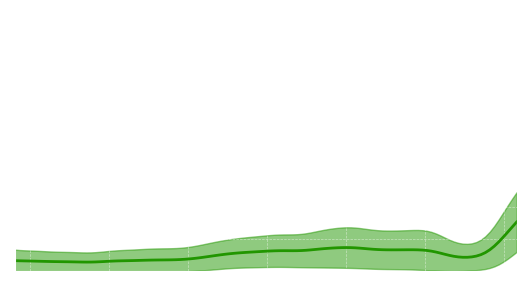

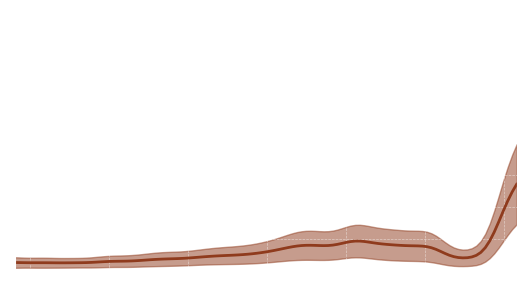

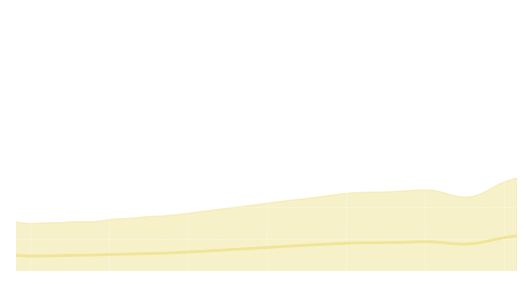

In [74]:
# plot mean coral, mean algae, mean geological
# remap classes
three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

wvs = df.columns
three_endmembers = {}
std_three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[wvs]
    std_three_endmembers[cat] = df.loc[ind].std(axis=0).loc[wvs]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])
three_color_dict = {
    'algae': "#219600",
    "coral": "#8f3b1d",
    "sand": "#f0e497",
}
for cat, spectrum in three_endmembers.items():
    fig, ax = plt.subplots(figsize=[5.15, 2.75], constrained_layout=True)
    ax.plot(spectrum.index, spectrum.values, color=three_color_dict[cat], lw=2, alpha=1)
    ax.fill_between(spectrum.index, spectrum.values - std_three_endmembers[cat].values, spectrum.values + std_three_endmembers[cat].values, color=three_color_dict[cat], alpha=0.5)
    # ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    # ax.set_xlabel('Wavelength (nm)', color="white")
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
    ax.set_xlim(min(remapped_df.columns), max(remapped_df.columns))
    plotting.format_axis_for_ppt(ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.set_ylabel('Reflectance', color="white")
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    ax.text(
        0.5, 0.9, cat, 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=16,
        color='white'
    )

### PCA

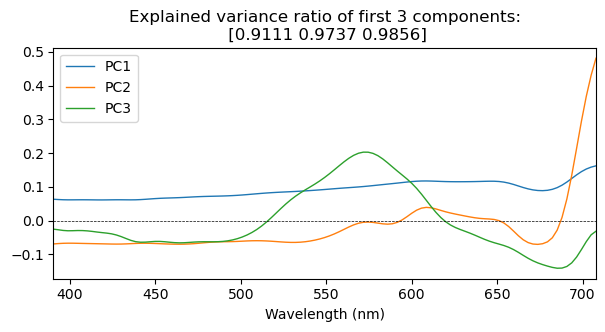

In [80]:
# N-component PCA
pca = PCA(3)
pca.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(pca.components_):
    ax.plot(df.columns, component, label=f'PC{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')

# formatting
ax.legend()
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())
ax.set_title('Explained variance ratio of first 3 components:\n ' + str(np.round(pca.explained_variance_ratio_.cumsum(), 4)));

### Truncated SVD

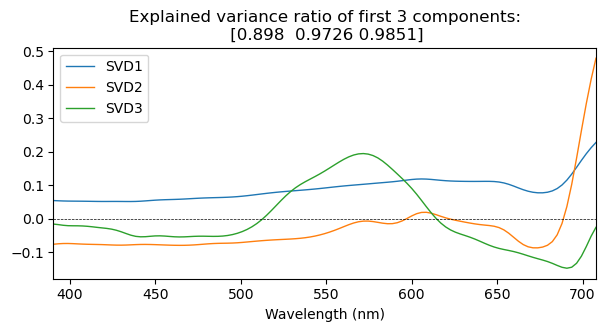

In [82]:
svd = TruncatedSVD(3)
svd.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(svd.components_):
    ax.plot(df.columns, component, label=f'SVD{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')
 
# formatting
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())
ax.legend()
ax.set_title('Explained variance ratio of first 3 components:\n ' + str(np.round(svd.explained_variance_ratio_.cumsum(), 4)));